In [ ]:
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

In [2]:
set2_cmap = sns.color_palette("Set2", 4)
set2_cmap

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)]

## Read jet core algorithm anomalies

In [3]:
jca_name = "u"

In [4]:
var_names = {"k06": "weighted_average_ws", "s09": "jet_occurence", "m11": "jet_region_mask", "po13": "local_wind_maxima",  "k14": "jet_occurence", "u": "u"}
var_name = var_names[jca_name]
var_name_norm = f'{var_name}_norm'

In [5]:
jca = xr.open_mfdataset(f'../data/jet_stream/{jca_name}_*.nc')

### Read trough or npj csv data

In [6]:
trough_df = pd.read_csv(f'outputs/trough_df_{jca_name}.csv')
npj_df = pd.read_csv(f'outputs/npj_df_{jca_name}.csv')

In [7]:
trough_prop_df = (trough_df / trough_df.max())
npj_prop_df = (npj_df / npj_df.max())

# load extreme ('persistent') cold data

In [8]:
extreme_cold_persist_thresh = xr.open_dataset('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/input_preparation/outputs/ar6_3daypersist_extreme_cold_detrend_95thpercthresh_q01.nc')

In [9]:
extreme_cold_persist_thresh['cold_air_event_CNA'].to_pandas().value_counts()

cold_air_event_CNA
0    29525
1      910
Name: count, dtype: int64

# Main functions

In [10]:
NUM_DAYS_BREAK = 1


def cluster_datetimes(dates):
    clusters = []
    current_cluster = [dates[0].data]
    
    for i in range(1, len(dates)):
        if pd.to_timedelta(int(dates[i] - dates[i - 1])).days > NUM_DAYS_BREAK:
            # Start a new cluster
            clusters.append(current_cluster)
            current_cluster = [dates[i].data]
        else:
            # Add to the current cluster
            current_cluster.append(dates[i].data)
    
    # Add the last cluster
    clusters.append(current_cluster)
    
    return clusters

# Look at all cold air codes 

In [11]:
all_cold_event_codes = np.unique(extreme_cold_persist_thresh['cold_air_event_stacked_names'])

# Plot lagged composite

In [12]:
def plot_lag_composite(coldair_type, lag, ax, cbar=False, subset=True):
    onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == coldair_type)\
                                        ).dropna(dim='time')
    onetype_coldair_event_djf = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin([SEASON_TO_USE]))
    onetype_coldair_event_lagged_times = onetype_coldair_event_djf.time + np.timedelta64(lag, 'D')
    onetype_coldair_event_lagged_times = onetype_coldair_event_lagged_times[onetype_coldair_event_lagged_times > jca.time[0]]

    cold_air_event_dateclusters_lagged = cluster_datetimes(onetype_coldair_event_lagged_times)
    
    jca_my_persist_lagged = jca.sel(time=onetype_coldair_event_lagged_times)
    
    for ind, dt_cluster in enumerate(cold_air_event_dateclusters_lagged):
        if ind == 0:
            jca_my_persist_lagged_weighted = jca_my_persist_lagged.sel(time=dt_cluster).mean('time')
        else:
            jca_my_persist_lagged_weighted = xr.concat([jca_my_persist_lagged_weighted, jca_my_persist_lagged.sel(time=dt_cluster).mean('time')], dim='time')
    jca_my_persist_lagged_mean_weighted = jca_my_persist_lagged_weighted.mean('time')
    jca_my_persist_lagged_norm_mean = jca_my_persist_lagged[var_name_norm].mean('time')
    sign_crosshatching_lagged = np.sign(jca_my_persist_lagged_weighted[var_name_norm]) == np.sign(jca_my_persist_lagged_mean_weighted[var_name_norm])
    sign_crosshatching_lagged_time_mean = sign_crosshatching_lagged.sum(('time'))
    sign_crosshatching_lagged_time_mean_mask = (sign_crosshatching_lagged_time_mean / jca_my_persist_lagged_weighted.time.size)  > 0.66
    if subset:
        if cbar:
            (jca_my_persist_lagged_mean_weighted[var_name_norm]\
             * sign_crosshatching_lagged_time_mean_mask).plot(\
                                ax=ax, transform=box_proj, vmin=-20, vmax=20, cmap='RdBu_r',\
                                cbar_kwargs={'shrink': 0.8, 'location':'bottom',\
                                            'label': 'TODO Anomaly ($ms^{-1}$)'})
        else:
            (jca_my_persist_lagged_mean_weighted[var_name_norm]\
             * sign_crosshatching_lagged_time_mean_mask).plot(\
                                ax=ax, transform=box_proj, vmin=-20, vmax=20, cmap='RdBu_r',\
                                add_colorbar=False)
    else:
        return jca_my_persist_lagged_mean_weighted
    return ax

# Plot direct comparison

season: DJF


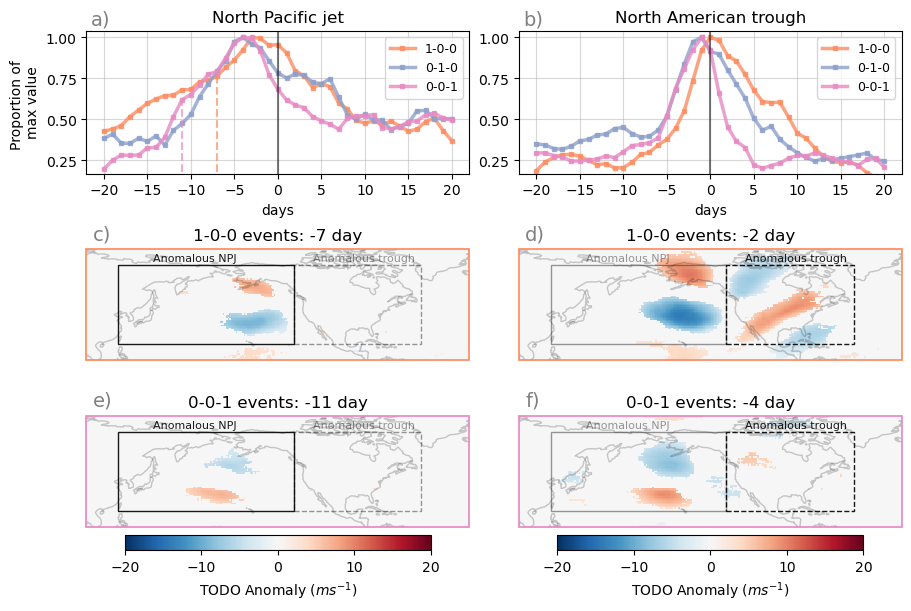

In [13]:
SEASON_TO_USE = 'DJF'

proj = ccrs.PlateCarree(central_longitude=180)
box_proj = ccrs.PlateCarree(central_longitude=0)

# ONSETS as determined by above 0.6 of max threshold
npj_onset_100 = -7
npj_onset_001 = -11
trough_onset_100 = -2
trough_onset_001 = -4

fig_labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

fig = plt.figure(figsize=(9, 6), constrained_layout=True) #9, 5 best ratio
gs = plt.GridSpec(3, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[1, 0], projection=proj)
ax4 = fig.add_subplot(gs[1, 1], projection=proj, sharex=ax3, sharey=ax3)
ax5 = fig.add_subplot(gs[2, 0], projection=proj, sharex=ax3, sharey=ax3)
ax6 = fig.add_subplot(gs[2, 1], projection=proj, sharex=ax3, sharey=ax3)

# ax1.plot(np.arange(-20, 21), np.array(npj_vals_000) / np.array(npj_vals_000).max(), alpha=.6, color=set2_cmap[0])
# ax2.plot(np.arange(-20, 21), np.array(trough_vals_000) / np.array(trough_vals_000).max(), alpha=.6, color=set2_cmap[0])
# linestyles_to_use = ['-', '--', '-.']
for ind, col in enumerate(trough_prop_df.columns):
    ax1.plot(np.arange(-20, 21), npj_prop_df[col], linewidth=2.5, color=set2_cmap[ind+1], alpha=.8, marker='s', markersize=3)
    ax2.plot(np.arange(-20, 21), trough_prop_df[col], linewidth=2.5, color=set2_cmap[ind+1], alpha=.8 , marker='s', markersize=3)

ax1.vlines(x=npj_onset_100, ymin=0.178, ymax=npj_prop_df.iloc[20+npj_onset_100]['100'],\
           color=set2_cmap[1], linestyle='--', linewidth=1.5, alpha=.7)
ax1.vlines(x=npj_onset_001, ymin=0.178, ymax=npj_prop_df.iloc[20+npj_onset_001]['001'],\
           color=set2_cmap[3], linestyle='--', linewidth=1.5, alpha=.7)
# ax2.vlines(x=trough_onset_100, ymin=0.178, ymax=trough_prop_df.iloc[20+trough_onset_100]['100'],\
#            color=set2_cmap[1], linestyle='--', linewidth=1.5, alpha=.7)
# ax2.vlines(x=trough_onset_001, ymin=0.178, ymax=trough_prop_df.iloc[20+trough_onset_001]['001'],\
#            color=set2_cmap[3], linestyle='--', linewidth=1.5, alpha=.7)


ax1.set_title("North Pacific jet")
ax2.set_title("North American trough")
ax1.set_ylabel("Proportion of \nmax value", size=10)

for ind, ax in enumerate([ax1, ax2]):
    ax.grid(axis='both', alpha=.5)
    ax.axvline(0, color='k', alpha=.5)
    ax.legend(['W', 'C', 'E'], fontsize=9)
    # ax.axhline(0.6, xmin=-0.025, xmax=0.025, alpha=.3, color='m', clip_on=False)
    ax.set_yticks(np.arange(0, 1.01, 0.25))
    ax.set_ylim(0.168, 1.04)
    ax.set_xlabel("days")
    ax.text(s=fig_labels[ind], x=-21.5, y=1.08, c='grey', size=14)


### MAP PLOTS

print('season:', SEASON_TO_USE)
plot_lag_composite('100', npj_onset_100, ax3)
plot_lag_composite('100', trough_onset_100, ax4)
plot_lag_composite('001', npj_onset_100, ax5, cbar=True)
plot_lag_composite('001', trough_onset_001, ax6, cbar=True)

# ax3.set_title(f"{npj_onset_100} day composite (1-0-0)")#, color=set2_cmap[1])
# ax4.set_title(f"{trough_onset_100} day composite (1-0-0)")#, color=set2_cmap[1])
# ax5.set_title(f"{npj_onset_001} day composite (0-0-1)")#, color=set2_cmap[3])
# ax6.set_title(f"{trough_onset_001} day composite (0-0-1)")#, color=set2_cmap[3])

ax3.set_title(f"1-0-0 events: {npj_onset_100} day")#, color=set2_cmap[1])
ax4.set_title(f"1-0-0 events: {trough_onset_100} day")#, color=set2_cmap[1])
ax5.set_title(f"0-0-1 events: {npj_onset_001} day")#, color=set2_cmap[3])
ax6.set_title(f"0-0-1 events: {trough_onset_001} day")#, color=set2_cmap[3])

for ind, ax in enumerate([ax3, ax4, ax5, ax6]):
    ax.set_extent([100, 340, 10, 80], crs=box_proj)
    ax.coastlines(alpha=.2)
    if ind > 1:
        ax.spines['geo'].set_edgecolor(set2_cmap[3])
    else:
        ax.spines['geo'].set_edgecolor(set2_cmap[1])
    ax.spines['geo'].set_linewidth(1.25)
    npj_box_alpha = .9
    trough_box_alpha = .9
    
    if ind % 2 == 0:
        trough_box_alpha = .4
    else:
        npj_box_alpha = .4
        
    ax.text(s="Anomalous NPJ", x=142, y=72, size=8, transform=ccrs.PlateCarree(), alpha=npj_box_alpha)
 
    ax.add_patch(mpatches.Rectangle(xy=[120, 20], width=110, height=50,
                                facecolor='none', edgecolor='k', alpha=npj_box_alpha,
                                transform=ccrs.PlateCarree()))
    ax.text(s="Anomalous trough", x=242, y=72, size=8, transform=ccrs.PlateCarree(), alpha=trough_box_alpha)
    ax.add_patch(mpatches.Rectangle(xy=[230, 20], width=80, height=50,
                                facecolor='none', linestyle='--',
                                    edgecolor='k', alpha=trough_box_alpha,
                                transform=ccrs.PlateCarree()))
    ax.text(s=fig_labels[ind+2], x=-76, y=86, c='grey', size=14)
# fig.savefig(f"figures/figure_4_timings_{jca_name}.png", bbox_inches='tight', dpi=300)

In [14]:
jca_name

'u'

# Compare 

In [15]:
var_names_to_plot = ['k06', 'm11', 'k14', 'u', 'zg']

In [31]:
cao_code = '001'

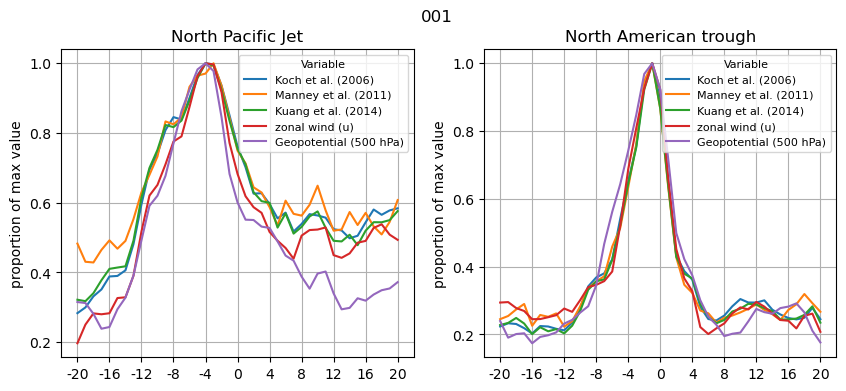

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for var_nm in var_names_to_plot:
    trough_df = pd.read_csv(f'outputs/trough_df_{var_nm}.csv')
    npj_df = pd.read_csv(f'outputs/npj_df_{var_nm}.csv')
    trough_prop_df = (trough_df / trough_df.max())
    npj_prop_df = (npj_df / npj_df.max())
    axes[0].plot(npj_prop_df[cao_code], label=var_nm)
    axes[1].plot(trough_prop_df[cao_code], label=var_nm)

for ax in axes:
    ax.legend(['Koch et al. (2006)', 'Manney et al. (2011)', 'Kuang et al. (2014)', 'zonal wind (u)', 'Geopotential (500 hPa)'], title='Variable', title_fontsize=8, fontsize=8)
    ax.grid(axis='both')
    ax.set_xticks(np.arange(0, 41, 4))
    ax.set_xticklabels(np.arange(-20, 21, 4))
    ax.set_yticks(np.arange(0.2, 1.2, 0.2))
    ax.set_ylabel("proportion of max value")
axes[0].set_title("North Pacific Jet")
axes[1].set_title("North American trough")
fig.suptitle(cao_code)
# fig.savefig(f'figures/comarison_alljca_zg_lags_{cao_code}.png')